In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
import time
import pickle

In [288]:
data = pd.read_csv('loan.csv')

In [289]:
for col in data.columns:
    print(col)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
b

## Preprocessing

In [290]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", 
            "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

def loan_condition(status):
    if status in bad_loan:
        return 1
    else:
        return 0
    
    
y = data['loan_status'].apply(loan_condition)
y.name = 'bad_loan'

In [291]:
def term_str_to_int(term_str):
    return [int(s) for s in term_str.split() if s.isdigit()][0]
data['term'] = data['term'].apply(term_str_to_int)

In [292]:
def grade_str_to_int(grade_str):
    return ord(grade_str.lower()) - 97
data['grade'] = data['grade'].apply(grade_str_to_int)

In [293]:
def subgrade_str_to_int(subgrade_str):
    return grade_str_to_int(subgrade_str[0]) * 5 + (int(subgrade_str[1])-1)
data['sub_grade'] = data['sub_grade'].apply(subgrade_str_to_int)

In [294]:
def emplength_str_to_int(emplength_str):
    if pd.isnull(emplength_str):
        return np.nan
    else:
        return int(re.sub('[^0-9]+', '', str(emplength_str)))
data['emp_length'] = data['emp_length'].apply(emplength_str_to_int)

In [295]:
def pymntplan_str_to_int(pymntplan_str):
    if pymntplan_str == 'y':
        return 1
    else:
        return 0
data['pymnt_plan'] = data['pymnt_plan'].apply(pymntplan_str_to_int)

In [296]:
data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%Y')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%Y')
data['sec_app_earliest_cr_line'] = pd.to_datetime(data['sec_app_earliest_cr_line'], 
                                                  format='%b-%Y')
def month_diff(a, b):
    return 12 * (a.dt.year - b.dt.year) + (a.dt.month - b.dt.month)

data['earliest_cr_line'] = month_diff(data['issue_d'], data['earliest_cr_line'])
data['sec_app_earliest_cr_line'] = month_diff(data['issue_d'], 
                                              data['sec_app_earliest_cr_line'])

In [297]:
def applicationtype_str_to_int(applicationtype_str):
    if applicationtype_str == 'Joint App':
        return 1
    else:
        return 0
data['application_type_joint'] = data['application_type'].apply(applicationtype_str_to_int)

In [298]:
def disbursement_str_to_int(disbursement_str):
    if disbursement_str == 'Cash':
        return 1
    else:
        return 0
data['disbursement_method_cash'] = data['disbursement_method'].apply(disbursement_str_to_int)

In [300]:
to_dummies = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 
              'verification_status_joint']
data = pd.get_dummies(data, prefix=to_dummies, columns=to_dummies)

In [333]:
fill_na_100 = ['dti', 'pct_tl_nvr_dlq']
data[fill_na_100] = data[fill_na_100].fillna(100)

data.fillna(0, inplace=True)

In [336]:
data.to_pickle('data.pkl.gzip')

In [337]:
y.to_pickle('y.pkl.gzip')

## Feature selection and transformation

In [198]:
data = pd.read_pickle('data.pkl.gzip')
y = pd.read_pickle('y.pkl.gzip')

In [199]:
data = data.loc[:,~data.columns.str.startswith('addr_state')]

In [200]:
pos_samples = y[y == 1].sample(frac=0.5, axis=0).index
neg_samples = y[y == 0].sample(len(pos_samples), axis=0).index
samples = pos_samples.union(neg_samples)
len(samples)

297032

In [201]:
pos_samples_out = y[~y.index.isin(samples)][y == 1].index
neg_samples_out = y[~y.index.isin(samples)][y == 0].sample(len(pos_samples_out), axis=0).index
samples_out = pos_samples_out.union(neg_samples_out)
len(samples_out)

297034

In [206]:
columns_of_interest = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 
                       'home_ownership_RENT', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 
                       'home_ownership_ANY', 'home_ownership_NONE', 'home_ownership_OWN', 'annual_inc', 
                       'purpose_credit_card', 'purpose_debt_consolidation', 
                       'purpose_small_business', 'purpose_home_improvement', 'purpose_car', 'purpose_moving',
                       'purpose_major_purchase', 'purpose_vacation', 'purpose_other', 'purpose_renewable_energy',
                       'purpose_medical', 'purpose_house', 'purpose_wedding', 'dti', 'total_acc', 
                       'verification_status_Not Verified', 'verification_status_Verified', 
                       'verification_status_Source Verified']
extra_cols = ['total_rec_prncp', 'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee']
columns_of_interest = columns_of_interest + extra_cols
len(columns_of_interest)

37

In [203]:
corrs = pd.Series(index=data.columns)

for col in data.columns:
    corrs[col] = y[samples].corr(data.loc[samples, col])
    
corrs = corrs.reindex(corrs.abs().sort_values(ascending=False).index)

In [204]:
for key, value in corrs[~corrs.index.isin(columns_of_interest)].items():
    print(f'{key}: {value}')

total_rec_prncp: -0.3763818146413725
last_pymnt_amnt: -0.34869557048568534
out_prncp: -0.27253995406040793
out_prncp_inv: -0.2725178258510127
total_pymnt_inv: -0.22638873617249958
total_pymnt: -0.22619756798443943
total_rec_late_fee: 0.14134639037714805
bc_open_to_buy: -0.13532160445135621
acc_open_past_24mths: 0.12513904478037846
total_bc_limit: -0.12070964521904778
max_bal_bc: -0.11817474872597357
inq_last_6mths: 0.11644913725620307
num_tl_op_past_12m: 0.10719104774283371
disbursement_method_cash: 0.10495692240371766
percent_bc_gt_75: 0.10276405000055192
tot_hi_cred_lim: -0.10083995374014099
revol_util: 0.09723890208033119
bc_util: 0.09416503873241457
avg_cur_bal: -0.09244691749270662
all_util: -0.08982638523376237
total_rev_hi_lim: -0.08595682503461875
tot_cur_bal: -0.08562246976772396
il_util: -0.0804038073573535
total_rec_int: 0.07549893524997216
open_act_il: -0.07283792190801971
sec_app_earliest_cr_line: -0.07009115469159886
total_bal_il: -0.0662075631047673
num_actv_rev_tl: 0.06

In [205]:
for key, value in corrs[corrs.index.isin(columns_of_interest)].items():
    print(f'{key}: {value}')

sub_grade: 0.3255199079306604
grade: 0.3182789918719612
int_rate: 0.29508564294067885
verification_status_Not Verified: -0.13256073742843918
term: 0.1295616796954087
verification_status_Verified: 0.10924675361985436
home_ownership_MORTGAGE: -0.07411257429381682
home_ownership_RENT: 0.07351161041507226
purpose_credit_card: -0.05651734173228852
purpose_debt_consolidation: 0.05329125444354017
dti: 0.05150220700697062
installment: 0.049803227574352855
annual_inc: -0.04937312468260841
loan_amnt: 0.04265995890967563
purpose_small_business: 0.03008973792700615
emp_length: -0.025758137070311573
total_acc: 0.019822915117593952
verification_status_Source Verified: 0.018740387356018358
purpose_home_improvement: -0.018664063945407955
purpose_car: -0.017281431913123445
home_ownership_ANY: -0.009017260295534587
purpose_moving: 0.006853346474842932
purpose_major_purchase: -0.0058403630051237585
purpose_renewable_energy: 0.00462631270033234
purpose_vacation: -0.002922139727915756
purpose_house: -0.002

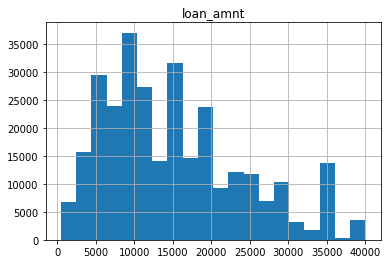

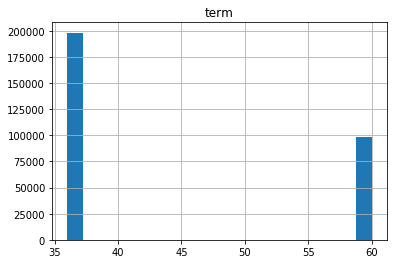

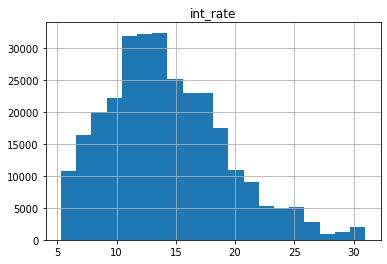

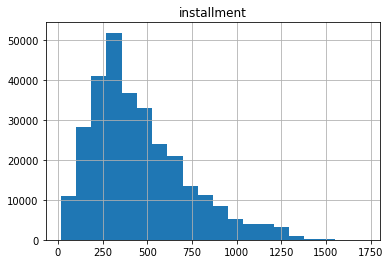

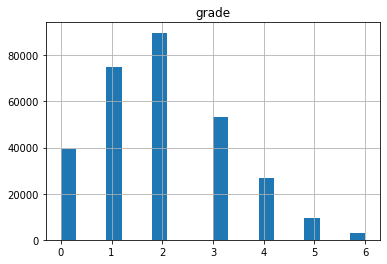

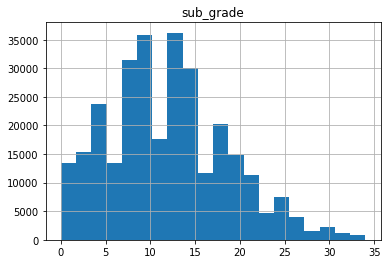

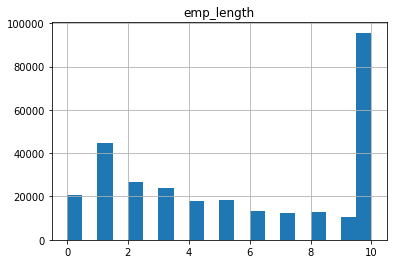

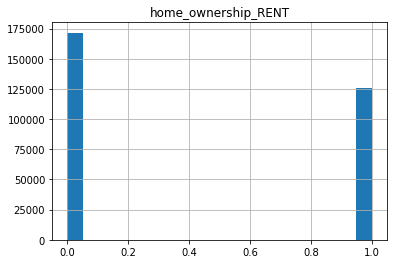

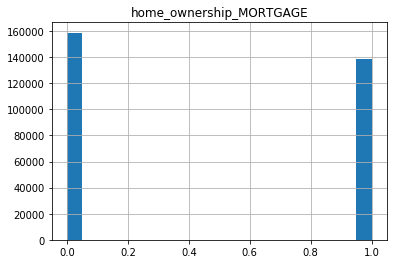

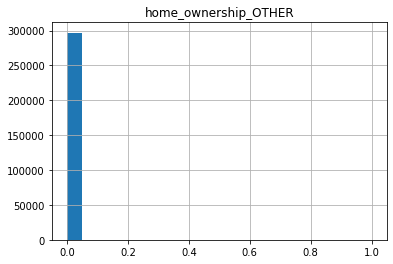

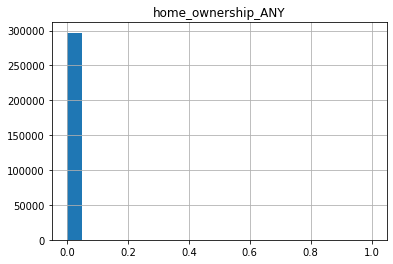

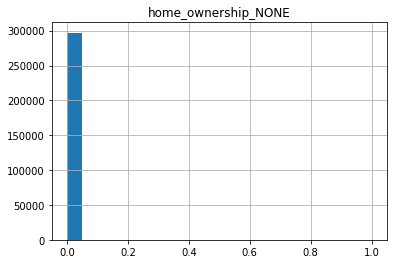

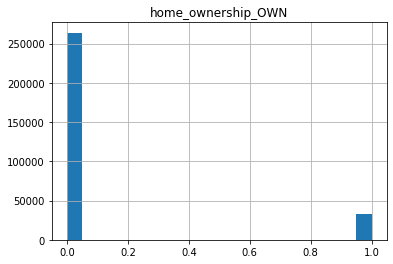

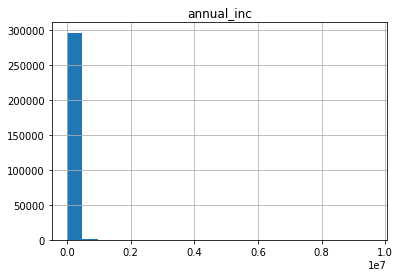

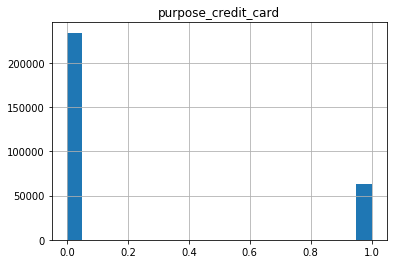

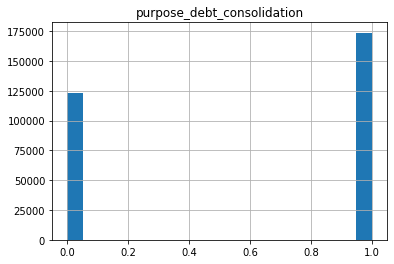

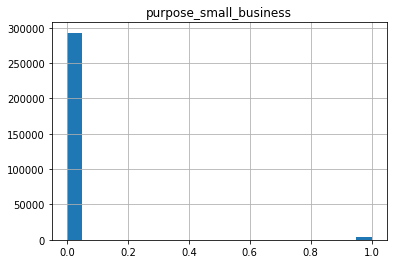

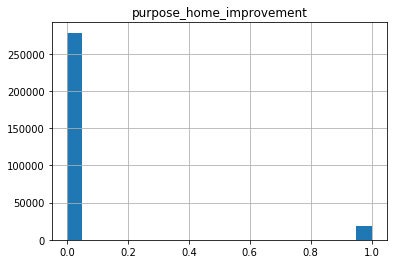

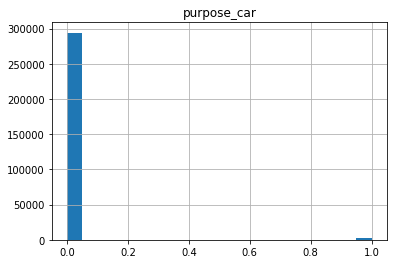

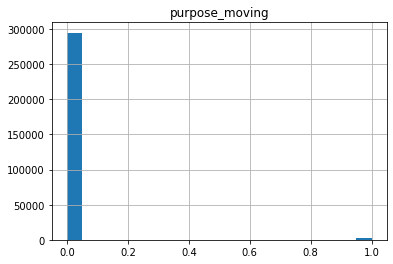

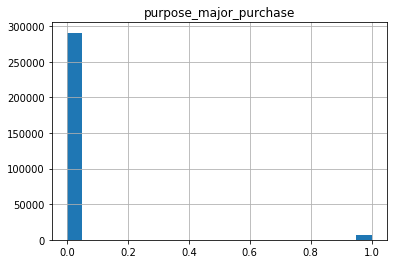

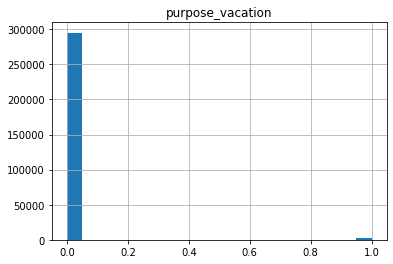

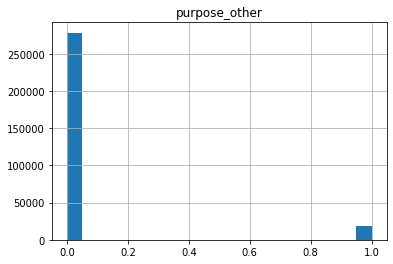

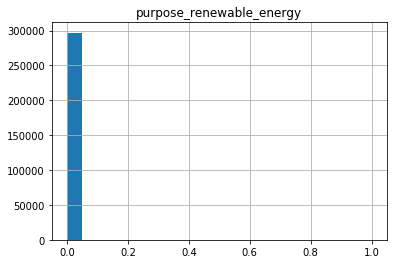

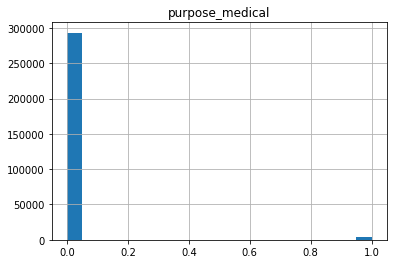

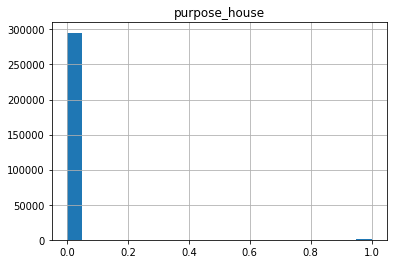

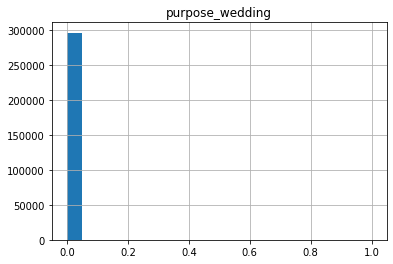

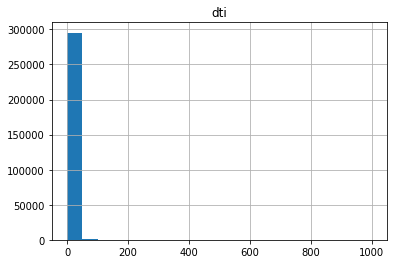

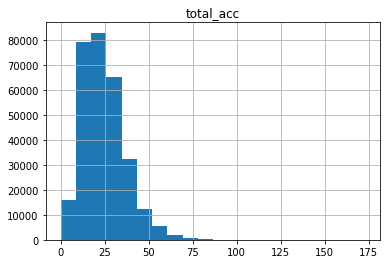

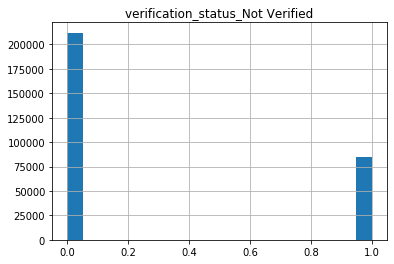

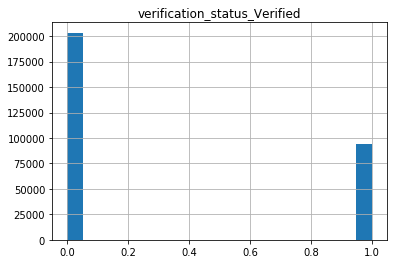

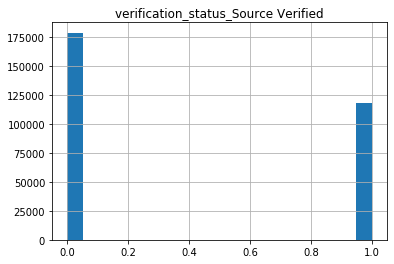

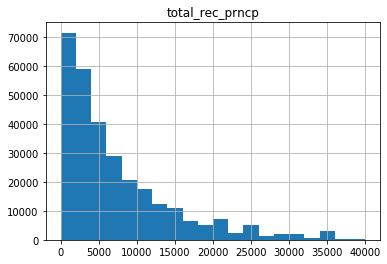

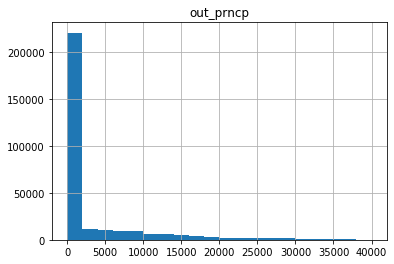

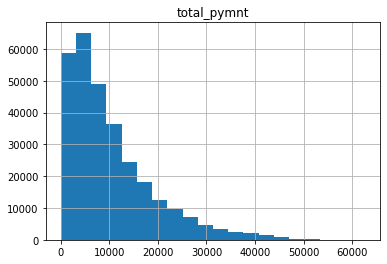

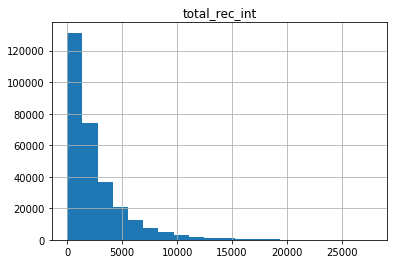

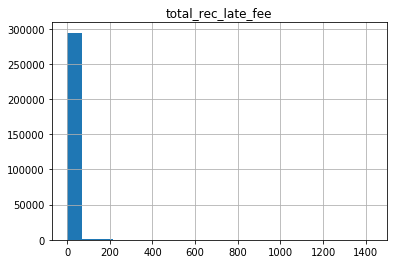

In [207]:
for col in columns_of_interest:
    data.loc[samples, col].hist(bins=20)
    plt.title(col)
    plt.show()

In [208]:
data = data[columns_of_interest]
data['term_long'] = (data['term'] - data['term'].min()) / (data['term'].max() - data['term'].min())
data.drop(columns=['term'], inplace=True)
for col in ['annual_inc', 'dti', 'total_acc', 'total_rec_prncp', 'out_prncp', 'total_pymnt', 
            'total_rec_int', 'total_rec_late_fee']:
    data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)
    data.drop(columns=[col], inplace=True)

<ipython-input-208-043367ffcb96>:6: RuntimeWarning: divide by zero encountered in log
  data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)
<ipython-input-208-043367ffcb96>:6: RuntimeWarning: invalid value encountered in log
  data[f'{col}_log'] = np.log(data[col]).clip(lower=0).fillna(0)


In [221]:
data.loc[samples].to_pickle('x_in_sample.pkl_gzip')
data.loc[samples_out].to_pickle('x_out_sample.pkl_gzip')
y[samples].to_pickle('y_in_sample.pkl.gzip')
y[samples_out].to_pickle('y_out_sample.pkl.gzip')

## Training and prediction

In [214]:
current_cols = []
possible_cols = list(data.columns)

for i in range(len(data.columns)):
    aics = []
    old_pvalues = []
    added_pvalues = []
    
    print('')
    print('----------------------------------------')

    for col in possible_cols:
        try:
            clf = sm.Logit(
                y[samples], 
                data.loc[samples, current_cols + [col]]
            ).fit(full_output=False, disp=False)
            aics.append(clf.aic)
            old_pvalues.append(clf.pvalues[:-1])
            added_pvalues.append(clf.pvalues[-1])
        except:
            aics.append(np.inf)
            old_pvalues.append([])
            added_pvalues.append(1)
            
    
    lowest_aic = 1e10
    for pvalue, aic in zip(added_pvalues, aics):
        if pvalue < 0.05 and aic < lowest_aic:
            lowest_aic = aic
            
    if lowest_aic == 1e10:
        print(added_pvalues)
        break
        
    best_col = aics.index(lowest_aic)
    
    print(f'--Best col: {possible_cols[best_col]} p-value={added_pvalues[best_col]}, aic={aics[best_col]}--')

    current_cols.append(possible_cols.pop(best_col))
    
    print(f'---- Current columns ----')
    for i, pvalue in enumerate(old_pvalues[best_col]):
        print(f'{current_cols[i]}: pvalue={pvalue}')
        if pvalue > 0.2:
            print(f'--Remove col: {current_cols[i]}, p-value={pvalue}--')
            possible_cols.append(current_cols.pop(i))
    
print('DONE')
print(current_cols)


----------------------------------------
--Best col: out_prncp_log p-value=0.0, aic=379127.2396589379--
---- Current columns ----

----------------------------------------
--Best col: grade p-value=0.0, aic=345985.04760162655--
---- Current columns ----
out_prncp_log: pvalue=0.0

----------------------------------------
--Best col: total_rec_prncp_log p-value=0.0, aic=332143.49812600185--
---- Current columns ----
out_prncp_log: pvalue=0.0
grade: pvalue=0.0

----------------------------------------
--Best col: total_pymnt_log p-value=0.0, aic=212911.66541670143--
---- Current columns ----
out_prncp_log: pvalue=0.0
grade: pvalue=0.0
total_rec_prncp_log: pvalue=0.0

----------------------------------------
--Best col: term_long p-value=0.0, aic=196661.76477916108--
---- Current columns ----
out_prncp_log: pvalue=0.0
grade: pvalue=0.0
total_rec_prncp_log: pvalue=0.0
total_pymnt_log: pvalue=0.0

----------------------------------------
--Best col: total_rec_int_log p-value=0.0, aic=178519

--Best col: home_ownership_NONE p-value=2.730451642287406e-22, aic=137090.91511774677--
---- Current columns ----
out_prncp_log: pvalue=0.0
total_rec_prncp_log: pvalue=0.0
total_pymnt_log: pvalue=2.692594495717156e-303
term_long: pvalue=0.0
total_rec_int_log: pvalue=0.0
total_rec_late_fee_log: pvalue=0.0
int_rate: pvalue=0.0
installment: pvalue=2.940511214120451e-14
dti_log: pvalue=7.411552011345218e-27
home_ownership_RENT: pvalue=0.0
sub_grade: pvalue=0.0
home_ownership_OWN: pvalue=0.0
home_ownership_MORTGAGE: pvalue=0.0
home_ownership_ANY: pvalue=0.0
home_ownership_OTHER: pvalue=1.2287876860261711e-127
total_acc_log: pvalue=6.340908341564327e-64
verification_status_Not Verified: pvalue=1.6572473684241236e-35
annual_inc_log: pvalue=1.6864902674992732e-20

----------------------------------------
--Best col: verification_status_Source Verified p-value=1.3206332856971101e-08, aic=137060.63645826554--
---- Current columns ----
out_prncp_log: pvalue=0.0
total_rec_prncp_log: pvalue=0.0
tot

/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


--Best col: grade p-value=1.136283518216246e-07, aic=137034.50143478942--
---- Current columns ----
out_prncp_log: pvalue=0.0
total_rec_prncp_log: pvalue=0.0
total_pymnt_log: pvalue=2.2153839167817044e-305
term_long: pvalue=0.0
total_rec_int_log: pvalue=0.0
total_rec_late_fee_log: pvalue=0.0
int_rate: pvalue=0.0
installment: pvalue=2.439044839050582e-15
dti_log: pvalue=2.2858247308150033e-28
home_ownership_RENT: pvalue=0.0
sub_grade: pvalue=1.1087519075221165e-179
home_ownership_OWN: pvalue=0.0
home_ownership_MORTGAGE: pvalue=0.0
home_ownership_ANY: pvalue=0.0
home_ownership_OTHER: pvalue=5.04859461001912e-129
total_acc_log: pvalue=3.096509741409687e-63
verification_status_Not Verified: pvalue=2.4157651899621707e-42
annual_inc_log: pvalue=8.3159735971310825e-19
home_ownership_NONE: pvalue=6.50207296134741e-23
verification_status_Source Verified: pvalue=1.2192549282266205e-08

----------------------------------------
--Best col: emp_length p-value=6.921961502123429e-07, aic=137011.85923

/Users/jurrew27/anaconda3/envs/quant/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


In [215]:
# best_params = ['grade', 'annual_inc_log', 'sub_grade', 'int_rate', 'home_ownership_RENT', 
#                'verification_status_Not Verified', 'total_acc_log', 'verification_status_Verified', 
#                'verification_status_Source Verified', 'purpose_other', 'home_ownership_OWN', 'emp_length', 
#                'purpose_credit_card', 'purpose_house', 'dti_log', 'purpose_small_business', 'installment', 
#                'loan_amnt', 'term_long', 'purpose_car', 'purpose_wedding']
best_params = ['out_prncp_log', 'total_rec_prncp_log', 'total_pymnt_log', 'term_long', 'total_rec_int_log', 
               'total_rec_late_fee_log', 'int_rate', 'installment', 'dti_log', 'home_ownership_RENT', 
               'sub_grade', 'home_ownership_OWN', 'home_ownership_MORTGAGE', 'home_ownership_ANY', 
               'home_ownership_OTHER', 'total_acc_log', 'verification_status_Not Verified', 'annual_inc_log', 
               'home_ownership_NONE', 'verification_status_Source Verified', 'grade', 'emp_length', 
               'purpose_small_business', 'purpose_wedding', 'purpose_medical', 'purpose_home_improvement']

In [216]:
clf = sm.Logit(y[samples], data.loc[samples, best_params]).fit()

Optimization terminated successfully.
         Current function value: 0.230524
         Iterations 9


In [217]:
y_hat_insample = clf.predict(data.loc[samples, best_params])

In [218]:
y_hat_outsample = clf.predict(data.loc[samples_out, best_params])

In [222]:
with open('y_hat_in_sample.pkl', 'wb') as f:
    pickle.dump(y_hat_insample, f)

In [223]:
with open('y_hat_out_sample.pkl', 'wb') as f:
    pickle.dump(y_hat_outsample, f)

In [219]:
(y_hat_insample.round() == y[samples]).sum() / len(samples)

0.9304889708852918

In [220]:
(y_hat_outsample.round() == y[samples_out]).sum() / len(samples_out)

0.9300080125507517